<h1>Collecting and Preprocessing Data</h1>

<h4> <li>This notebook is concerned with gathering the data for the data mining task. Part of the data is from a data set on Kaggle. The other is fetched from Spotify's Web Api and preprocess to fit the format from the main dataset. <br> </h4>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import missingno as msno
import scipy
import warnings

In [2]:
warnings.simplefilter('always', category=UserWarning)

In [3]:
tracks_data = pd.read_csv('../data/top50s.csv')
tracks_data.head()

,title,artist,top genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
0,"Hey, Soul Sister",Train,neo mellow,2010,97,89,67,-4,8,80,217,19,4,83
1,Love The Way You Lie,Eminem,detroit hip hop,2010,87,93,75,-5,52,64,263,24,23,82
2,TiK ToK,Kesha,dance pop,2010,120,84,76,-3,29,71,200,10,14,80
3,Bad Romance,Lady Gaga,dance pop,2010,119,92,70,-4,8,71,295,0,4,79
4,Just the Way You Are,Bruno Mars,pop,2010,109,84,64,-5,9,43,221,2,4,78


<h3>Description of Data Set</h3>

<p>This data set contains data about Spotify's top tracks for years from 2010 to 2019. <br/> The data set was downloaded from Kaggle: <a href="https://www.kaggle.com/leonardopena/top-spotify-songs-from-20102019-by-year"><font color="gree">Top Spotify songs from 2010-2019 - BY YEAR</font></a><br> In order to be more up to date, I am going to collect data for the top tracks of 2020 using Spotify's Web Api. Additionally, I am going to try and enrich the data set with some features for the artists. </p>

<h1>1. Fetching Data and Preparing the Data Set</h1>

<p>Setting up developer credentials for api use</p>

In [4]:
def set_up_spotify_credentials():
  cid = '88a51d84a8b44fe88e8adcb2e4728a07'
  secret = '00e8860dd9e547978fe714b97c31d178'
  client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
  sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
  return sp

<p>Extracting songs from top 50 playlist generated by Spotify for 2020.<br>
You can find the playlist <a href="https://open.spotify.com/playlist/37i9dQZF1DX7Jl5KP2eZaS"><font color='gree'>here</a></font></p>

In [5]:
def extract_track_data(pid):
  artist_name = []
  artist_id = []
  track_name = []
  popularity = []
  track_id = []
  duration = []
  sp = set_up_spotify_credentials()
  track_results = sp.playlist(playlist_id=pid)
  for i, tr in enumerate(track_results['tracks']['items']):
    artist_name.append(tr['track']['artists'][0]['name'])
    artist_id.append(tr['track']['artists'][0]['id'])
    track_name.append(tr['track']['name'])
    track_id.append(tr['track']['id'])
    popularity.append(tr['track']['popularity'])
    duration.append(tr['track']['duration_ms']/1000)
  return artist_name, artist_id, track_name, popularity, track_id, duration

In [6]:
artist_name, artist_id, track_name, popularity, track_id, duration = extract_track_data('37i9dQZF1DX7Jl5KP2eZaS')

<p>Now we have the ids of the top 50 tracks of 2020 and the artists' ids. <br>
We can now extract the audio features for each track and data about the artists using the provided ids, again using Spotify's Api.</p>

In [8]:
sp = set_up_spotify_credentials()
tracks = []
for id in track_id:
  tracks = sp.audio_features(tracks=track_id)

In [9]:
artists = []
artists = sp.artists(artist_id)

<p>Now I am going to create data frames for easier manipulation. <br>
I am going to rename the features to make them compatible in the new and old dataset and finaly concatenate the two datasets into one.</p>

In [10]:
artists_2020 = pd.DataFrame(artists['artists'])
artists_2020_features = artists_2020[['followers', 'genres', 'name', 'popularity']]

In [11]:
rename_columns_mapper = {'bpm': 'tempo', 'nrgy' : 'energy', 
                         'dnce': 'danceability', 'dB': 'loudness',
                         'live' : 'liveness', 'val' : 'valence', 
                         'dur': 'duration', 'acous': 'acousticness',
                         'spch': 'speechiness', 'pop': 'track_popularity'}

In [12]:
track_data = tracks_data.rename(columns=rename_columns_mapper)

In [13]:
track_features = list(rename_columns_mapper.values())

In [14]:
track_features[6] = 'duration_ms'

In [44]:
tracks_2020 = sp.audio_features(track_id)

In [46]:
tracks_2020 = pd.DataFrame(tracks_2020)

In [47]:
tracks_2020_only_features = tracks_2020[track_features[:-1]]

In [48]:
tracks_2020_only_features.insert(0, 'title', track_name)

In [49]:
tracks_2020_only_features.insert(1, 'year', 2020)

In [50]:
tracks_2020_only_features.insert(1, 'artist', artist_name)

In [51]:
artists_2020_features['genres'] = [artists_2020_features.iloc[i]['genres'][0] for i in range(len(artists_2020_features))]

<ipython-input-51-e51afc038511>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  artists_2020_features['genres'] = [artists_2020_features.iloc[i]['genres'][0] for i in range(len(artists_2020_features))]


In [52]:
tracks_2020_only_features.insert(2, 'top genre', artists_2020_features['genres'])

In [53]:
tracks_2020_only_features['track_popularity'] = popularity

<ipython-input-53-1be66d22cddc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks_2020_only_features['track_popularity'] = popularity


In [54]:
tracks_2020_only_features['duration_ms'] = tracks_2020_only_features['duration_ms'] / 1000

<ipython-input-54-a8878de47e77>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks_2020_only_features['duration_ms'] = tracks_2020_only_features['duration_ms'] / 1000


In [55]:
tracks_2020_only_features = tracks_2020_only_features.rename(columns={'duration_ms' : 'duration'})

In [56]:
full_tracks_data = pd.concat([track_data, tracks_2020_only_features])

In [58]:
full_tracks_data.to_csv('../data/tracks_including_2020.csv', index=False)

In [59]:
complete_data = pd.read_csv('../data/tracks_including_2020.csv')
complete_data.head()

,title,artist,top genre,year,tempo,energy,danceability,loudness,liveness,valence,duration,acousticness,speechiness,track_popularity
0,"Hey, Soul Sister",Train,neo mellow,2010,97.0,89.0,67.0,-4.0,8.0,80.0,217.0,19.0,4.0,83
1,Love The Way You Lie,Eminem,detroit hip hop,2010,87.0,93.0,75.0,-5.0,52.0,64.0,263.0,24.0,23.0,82
2,TiK ToK,Kesha,dance pop,2010,120.0,84.0,76.0,-3.0,29.0,71.0,200.0,10.0,14.0,80
3,Bad Romance,Lady Gaga,dance pop,2010,119.0,92.0,70.0,-4.0,8.0,71.0,295.0,0.0,4.0,79
4,Just the Way You Are,Bruno Mars,pop,2010,109.0,84.0,64.0,-5.0,9.0,43.0,221.0,2.0,4.0,78


In [60]:
artist_names_to_2019 = track_data['artist']

<p>Now let's find followers and popularity for artists from the Kaggle dataset by using the Search Api</p>

In [61]:
artist_details = []
for artist in artist_names_to_2019:
 artist_details.append(sp.search(artist, type='artist'))

In [62]:
followers = []
popularity = []
for i, ar in enumerate(artist_details):
  name = ar['artists']['items'][0]['name']
  if name == artist_names_to_2019[i]:
    followers.append(ar['artists']['items'][0]['followers']['total'])
    popularity.append(ar['artists']['items'][0]['popularity'])
  else:
    followers.append(np.nan)
    popularity.append(np.nan)

In [63]:
artists_2020['followers'] = [artists_2020.iloc[i]["followers"]['total'] for i in range(len(artists_2020))]

In [64]:
followers.extend(artists_2020['followers'].values)

In [65]:
popularity.extend(artists_2020['popularity'].values)

In [66]:
complete_data.insert(3, 'artist_popularity', popularity)

In [67]:
complete_data.insert(3, 'followers', followers)

<p>To obtain followers in millions</p>

In [68]:
complete_data['followers'] = complete_data['followers'] / 1000000

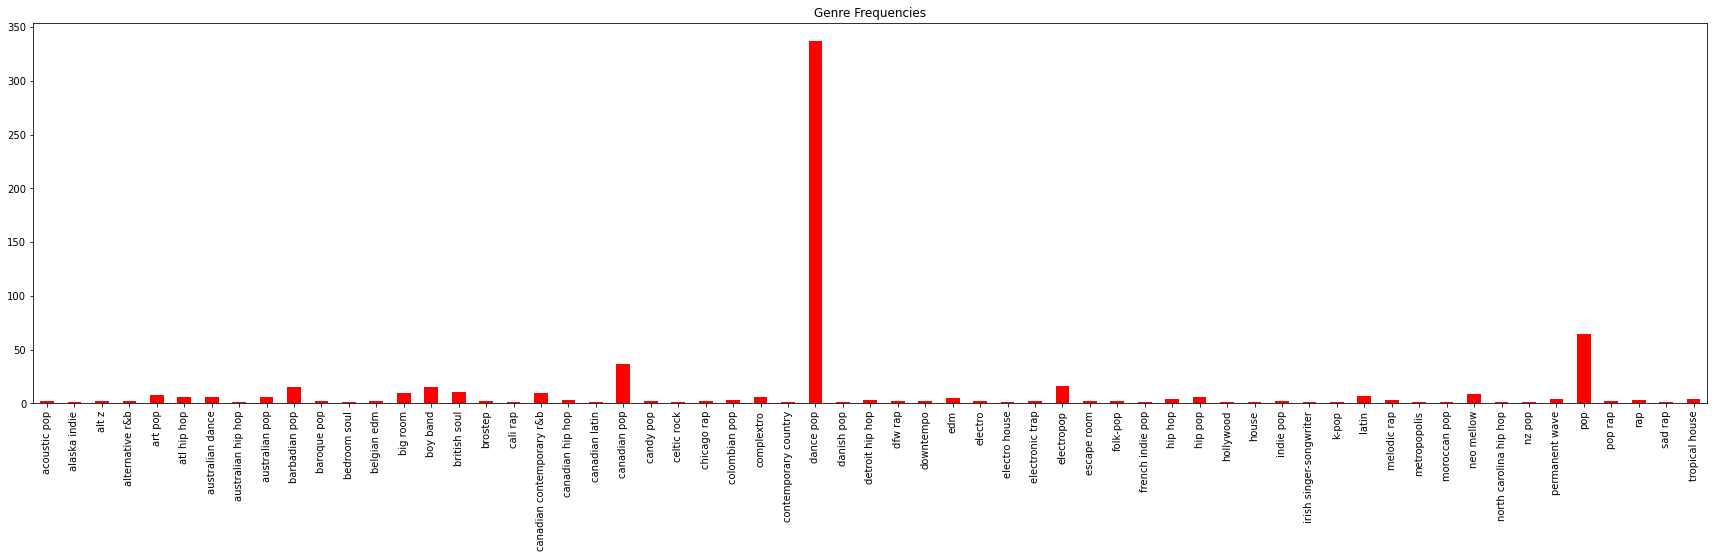

In [69]:
plt.figure()
complete_data['top genre'].value_counts().sort_index().plot.bar(color='red', figsize=(30, 7), title="Genre Frequencies")
plt.show()

<p>As we can see from the genre frequency plot, dance pop is the most frequent genre with more than half of the songs in the data set having this genre.</p>

In [71]:
pd.DataFrame(complete_data['top genre'].value_counts() / len(complete_data) * 100)

,top genre
dance pop,51.607963
pop,9.954058
canadian pop,5.666156
electropop,2.450230
barbadian pop,2.297090
...,...
sad rap,0.153139
danish pop,0.153139
moroccan pop,0.153139
contemporary country,0.153139


<p>Formally dance pop is the top genre in more than 51% of the tracks.</p>

In [73]:
complete_data['is_dance_pop'] = [1 if complete_data.iloc[i]['top genre'] == 'dance pop' else 0  for i in range(len(complete_data))]

<p>We can use this as a target variable if we want to perform binary 
classification, of course we will need to remove the 'top genre' variable for that matter. We are going to have an almost perfectly balanced target.</p>

In [75]:
complete_data[complete_data.columns.drop(['top genre'])].to_csv('../data/tracks_with_binary_target.csv', index=False)

In [76]:
np.unique(complete_data['top genre'])

array(['acoustic pop', 'alaska indie', 'alt z', 'alternative r&b',
       'art pop', 'atl hip hop', 'australian dance', 'australian hip hop',
       'australian pop', 'barbadian pop', 'baroque pop', 'bedroom soul',
       'belgian edm', 'big room', 'boy band', 'british soul', 'brostep',
       'cali rap', 'canadian contemporary r&b', 'canadian hip hop',
       'canadian latin', 'canadian pop', 'candy pop', 'celtic rock',
       'chicago rap', 'colombian pop', 'complextro',
       'contemporary country', 'dance pop', 'danish pop',
       'detroit hip hop', 'dfw rap', 'downtempo', 'edm', 'electro',
       'electro house', 'electronic trap', 'electropop', 'escape room',
       'folk-pop', 'french indie pop', 'hip hop', 'hip pop', 'hollywood',
       'house', 'indie pop', 'irish singer-songwriter', 'k-pop', 'latin',
       'melodic rap', 'metropopolis', 'moroccan pop', 'neo mellow',
       'north carolina hip hop', 'nz pop', 'permanent wave', 'pop',
       'pop rap', 'rap', 'sad rap', 'tro

Since there are a lot of unique genres, in order to make the data more suitable for multiclass classification a hierarchical grouping may be appropriate. I am going to use the hierarchical music genre classification provided in an article at <a href="https://www.researchgate.net/figure/Musical-Genres-Hiearachy_fig5_35389182"> Research gate</a> resulting in 10 unique genres. <img src="https://www.researchgate.net/profile/George-Tzanetakis/publication/35389182/figure/fig5/AS:372558584139779@1465836296395/Musical-Genres-Hiearachy.png" alt="1: Musical Genres Hiearachy"/>

Hierarchy for grouping taken from: <a href='https://musicmap.info/'>Musicmap</a>

In [77]:
genre_hierarchy = {
    'POP' : [
        'schlager',
        'skiffle',
        'brill building pop & crooners',
        'bubblegum & teenybop',
        'country pop',
        'country rock',
        'singer/songwriter',
        'pop rock', 
        'power pop',
        'soft rock',
        'adult contemporary',
        'synthpop',
        'new romantics',
        'hi-nrg',
        'eurodisco',
        'disco pop',
        'post-disco',
        'indie pop',
        'twee',
        'dream pop',
        'shoegaze',
        'asian pop',
        'britpop',
        'dance pop',
        'post-britpop',
        'electroclash',
        'nu wave',
        'indietronica',
        'chillwave',
        'electropop',
        'neo mellow',
        'pop',
        'canadian pop',
        'barbadian pop',
        'australian pop',
        'art pop',
        'colombian pop',
        'acoustic pop',
        'boy band',
        'baroque pop',
        'pop rap',
        'candy pop',
        'folk-pop',
        'metropopolis',
        'australian dance',
        'canadian contemporary r&b',
        'alternative r&b'
        'french indie pop',
        'danish pop',
        'moroccan pop',
        'french indie pop',
        'alternative r&b',
        'nz pop',
        'k-pop'
    ],
    'COUNTRY': [
        'classic country',
        'hillbilly',
        'western swing',
        'honky tonk', 
        'hardcore country',
        'bluegrass',
        'bakersfield',
        'nashville',
        'countrypolitan',
        'country pop',
        'country rock',
        'progressive country',
        'outlaw country',
        'urban country',
        'contemporary country',
        'neotraditionalists',
        'americana',
        'alternative country'
    ],
    'METAL': [
        'classic metal',
        'progressive metal',
        'power metal',
        'glam metal',
        'hair metal ',
        'pop metal',
        'nwobhm',
        'thrash metal',
        'extreme metal',
        'crossover thrash',
        'doom metal',
        'death metal',
        'grindcore',
        'stoner metal',
        'stoner rock',
        'sludge metal',
        'sludge rock',
        'symphonic metal',
        'gothic metal',
        'black metal',
        'nu metal', 
        'rap metal',
        'metalcore',
        'nwoahm'
    ],
    'BLUES': [
        'country blues',
        'folk blues',
        'delta blues',
        'vaudeville', 
        'classic blues',
        'boogie woogie',
        'piano blues',
        'electric blues',
        'texas blues',
        'jump blues',
        'chicago blues',
        'city blues',
        'urban blues',
        'west coast blues',
        'louisiana blues',
        'swamp blues',
        'british blues',
        'blues rock',
        'texas bluesrock',
        'modern electric blues',
        'soul blues',
        'southern soul ii',
        'hill country blues',
        'trance blues',
        'british soul'
    ],
    'JAZZ': [
        'new orleans jazz',
        'dixieland jazz',
        'chicago jazz',
        'swing',
        'big band',
        'third stream',
        'progressive jazz',
        'modal jazz',
        'new orleans',
        'dixieland jazz revivals',
        'bebop',
        'cool jazz',
        'west coast jazz',
        'hard bop',
        'soul jazz',
        'jazz funk',
        'free jazz',
        'avant-garde',
        'fusion',
        'jazz rock',
        'smooth jazz',
        'acid jazz',
        'jazzdance',
        'nu jazz',
        'electro jazz',
        'nordic jazz',
        'electro swing'
    ],
    'HIPHOP': [
        'old skool rap pioneers',
        'electro',
        'golden age rap',
        'hardcore rap',
        'miami bass & bounce',
        'gangsta rap',
        'jazz rap',
        'native tongue',
        'progressive rap',
        'nu skool rap',
        'reggaeton',
        'latin rap',
        'south rap', 
        'crunk',
        'snap',
        'east coast gangsta rap',
        'trap',
        'drill',
        'urban breaks',
        'nu r&b ii',
        'glitch hop',
        'wonky',
        'detroit hip hop',
        'hip pop',
        'atl hip hop',
        'chicago rap',
        'canadian hip hop',
        'australian hip hop',
        'hip hop',
        'melodic rap',
        'north carolina hip hop',
        'emo rap',
        'sad rap',
        'dfw rap',
        'cali rap',
        'rap'
    ],
    'DISCO': [
        'chicago house',
        'garage house',
        'acid house',
        'ambient house',
        'chill-out',
        'hip house',
        'eurodance',
        'deep house',
        'ibiza house',
        'dream house',
        'progressive house',
        'tech house',
        'electro house',
        'dutch house',
        'fidget house',
        'complextro',
        'nu disco',
        'funktronica',
        'moombahton',
        'disco',
        'big room',
        'house',
        'tropical house',
        'electronic trap',
        'edm'
    ],
    'ROCK': [
        'skiffle',
        "rock 'n roll",
        'rockabilly',
        'rock',
        'american & british folk revival',
        'surf rock',
        'instrumental rock',
        'garage rock',
        'permanent wave',
        'celtic rock',
        'alaska indie'
    ],
    'UNKNOWN': [
        'hollywood',
        'irish singer-songwriter',
        'belgian edm',
        'latin',
        'canadian latin',
        'downtempo',
        'brostep',
        'escape room',
        'bedroom soul',
        'alt z'
    ]
    
}

In [78]:
reverse_hierarchy = {}
for item in genre_hierarchy.items():
    for elem in item[1]:
        reverse_hierarchy[elem] = item[0]

In [79]:
complete_data['top genre'] = [reverse_hierarchy[genre] for genre in complete_data['top genre']]

In [80]:
complete_data[complete_data.columns.drop(['is_dance_pop'])].to_csv('../data/final_spotify_tracks.csv',index=False)